In [ ]:
import json
import pandas as pd
import numpy as np
import re

In [ ]:
file_dir='C://Users/alyss/Desktop/movies-etl'

In [ ]:
f'{file_dir}filename'

In [ ]:
with open(f'{file_dir}/wikipedia-movies.json',mode='r') as file:
    wiki_movies_raw=json.load(file)

In [ ]:
# how many titles are in the json
len(wiki_movies_raw)

In [ ]:
# first 5 records
wiki_movies_raw[:5]

In [ ]:
# last 5 records
wiki_movies_raw[-5:]

In [ ]:
# some records in the middle
wiki_movies_raw[3600:3605]

In [ ]:
# pulling kaggle data into dataframes
kaggle_metadata=pd.read_csv(f'{file_dir}/movies_metadata.csv',low_memory=False)
ratings=pd.read_csv(f'{file_dir}/ratings.csv')

In [ ]:
# inspect dataframes
kaggle_metadata.head()

In [ ]:
kaggle_metadata.tail()

In [ ]:
# randomly returns 5 rows
kaggle_metadata.sample(n=5)

In [ ]:
ratings.head()

In [ ]:
ratings.tail()

In [ ]:
ratings.sample(n=5)

In [ ]:
# read wiki_movies_raw into DF to inspect
wiki_movies_df=pd.DataFrame(wiki_movies_raw)

In [ ]:
# view top 5 rows of new dataframe
wiki_movies_df.head()

In [ ]:
# view list of columns in wiki_movies_df
wiki_movies_df.columns.tolist()

In [ ]:
# modify json to restrict to only entries that have a director and IMDB link
# using list comprehension
## save to intermediate variable
wiki_movies=[movie for movie in wiki_movies_raw
            if ('Director' in movie or 'Directed by' in movie)
                and 'imdb_link' in movie
                and 'No. of episodes' not in movie]
len(wiki_movies)

In [ ]:
# simple fxn to make copy of movie and return it
def clean_movie(movie): # fxn name = clean_movie, parameter = movie
    movie=dict(movie) # make nondestructive copy of incoming movie using dict() constructor
    return movie

In [ ]:
# look at languages, start w arabic
wiki_movies_df[wiki_movies_df['Arabic'].notnull()]

In [ ]:
# get url for two results 
wiki_movies_df[wiki_movies_df['Arabic'].notnull()]['url']

In [ ]:
# return all column names in alphabetical order
sorted(wiki_movies_df.columns.tolist())

In [ ]:
# make empty dict to hold all alt titles
def clean_movie(movie):
    movie=dict(movie) # create nondestruct copy
    alt_titles={} # empty dictionary
    
    #loop through list of all alt keys
    for key in ['Also known as','Arabic','Cantonese','Chinese','French',
                'Hangul','Hebrew','Hepburn','Japanese','Literally',
                'Mandarin','McCune–Reischauer','Original title','Polish',
                'Revised Romanization','Romanized','Russian',
                'Simplified','Traditional','Yiddish']:
        
        if key in movie: # check if current key exists in the movie object
            alt_titles[key]=movie[key] # if yes, remove key-value pair and add to alt_titles dict
            movie.pop(key)
            
        if len(alt_titles)>0: # after looping through all keys, add alt titles dict to movie object
            movie['alt_titles']=alt_titles
        
        # merge column names
        def change_column_name(old_name, new_name):
            if old_name in movie:
                movie[new_name] = movie.pop(old_name)
        change_column_name('Adaptation by', 'Writer(s)')
        change_column_name('Country of origin', 'Country')
        change_column_name('Directed by', 'Director')
        change_column_name('Distributed by', 'Distributor')
        change_column_name('Edited by', 'Editor(s)')
        change_column_name('Length', 'Running time')
        change_column_name('Original release', 'Release date')
        change_column_name('Music by', 'Composer(s)')
        change_column_name('Produced by', 'Producer(s)')
        change_column_name('Producer', 'Producer(s)')
        change_column_name('Productioncompanies ', 'Production company(s)')
        change_column_name('Productioncompany ', 'Production company(s)')
        change_column_name('Released', 'Release Date')
        change_column_name('Release Date', 'Release date')
        change_column_name('Screen story by', 'Writer(s)')
        change_column_name('Screenplay by', 'Writer(s)')
        change_column_name('Story by', 'Writer(s)')
        change_column_name('Theme music composer', 'Composer(s)')
        change_column_name('Written by', 'Writer(s)')
   
    return movie

In [ ]:
# make a list of cleaned movies using list comprehension
clean_movies=[clean_movie(movie) for movie in wiki_movies]

In [ ]:
# set wikimoviesdf to be df created from cleanmovies and print list of columns
wiki_movies_df=pd.DataFrame(clean_movies)
sorted(wiki_movies_df.columns.tolist())

In [ ]:
# look for imbd id's 
wiki_movies_df['imdb_id'] = wiki_movies_df['imdb_link'].str.extract(r'(tt\d{7})')
print(len(wiki_movies_df))

# drop rows with duplicate imdb ids
wiki_movies_df.drop_duplicates(subset='imdb_id', inplace=True)
print(len(wiki_movies_df))
wiki_movies_df.head()

In [ ]:
# remove mostly null columns using list comprehension
[[column, wiki_movies_df[column].isnull().sum()] for column in wiki_movies_df.columns] 

In [ ]:
# narrow column list down to colunms that have less than 90% null values
[column for column in wiki_movies_df.columns if wiki_movies_df[column].isnull().sum()<len(wiki_movies_df)*0.9]

In [ ]:
# assign keep columns to new variable
wiki_columns_to_keep=[column for column in wiki_movies_df.columns if wiki_movies_df[column].isnull().sum()<len(wiki_movies_df)*0.9]

# new df with only good columns
wiki_movies_df=wiki_movies_df[wiki_columns_to_keep]

In [ ]:
# how many columns we have now
len(wiki_movies_df.columns)

In [ ]:
# display datatypes for columns
wiki_movies_df.dtypes

In [ ]:
# look only at rows where box office data is defined
box_office=wiki_movies_df['Box office'].dropna()
len(box_office)

In [ ]:
# regex only works on strings
# use map() method to see which values are not strings
def is_not_a_string(x):
    return type(x) != str
box_office[box_office.map(is_not_a_string)]

In [ ]:
# same thing but using lambda instead
box_office[box_office.map(lambda x: type(x) != str)]

In [37]:
# join lists using join() if x type is list 
box_office = box_office.apply(lambda x: ' '.join(x) if type(x) == list else x)

In [38]:
# looks for box office nums in form of '$XXX.X xillion'
form_one = r'\$\d+\.?\d*\s*[mb]illion'

In [40]:
# count how many box office values match form one
# flags=re.ignorecase tells to ignore letter case
## na=False argument parses non-string data to False
## sum() to count True returns
box_office.str.contains(form_one, flags=re.IGNORECASE, na=False).sum()

3896

In [41]:
form_two=r'\$\d{1,3}(?:,\d{3})+'
box_office.str.contains(form_two,flags=re.IGNORECASE,na=False).sum()

1544

In [42]:
# create boolean series for each form
matches_form_one = box_office.str.contains(form_one, flags=re.IGNORECASE, na=False)
matches_form_two = box_office.str.contains(form_two,flags=re.IGNORECASE,na=False)

In [43]:
# see values that don't match either form
box_office[~matches_form_one & ~matches_form_two]

34                         US$ 4,212,828
79                              $335.000
110                   $4.35-4.37 million
130                        US$ 4,803,039
600                           $5000 (US)
731                         $ 11,146,270
957                             $ 50,004
1070                          35,254,617
1147    $ 407,618 (U.S.) (sub-total) [1]
1446                        $ 11,829,959
1480                          £3 million
1611                            $520.000
1865                        ¥1.1 billion
2032                                 N/A
2091                                $309
2130               US$ 171.8 million [9]
2257                   US$ 3,395,581 [1]
2263            $ 1,223,034 ( domestic )
2347                            $282.175
2638            $ 104,883 (US sub-total)
2665         926,423 admissions (France)
2697      $ 1.7 million (US) (sub-total)
2823                            $414.000
2924                            $621.000
3088           $

In [44]:
# add \s* after dollar signs to address extra space bw $ and digits in some values
form_one = r'\$\s*\d+\.?\d*\s*[mb]illion'
form_two = r'\$\s*\d{1,3}(?:,\d{3})+'

In [45]:
# account for periods being used as thousands separator instead of comma
# reject matches that return million or billion after 
form_two = r'\$\s*\d{1,3}(?:[,\.]\d{3})+(?!\s[mb]illion)'

In [46]:
# account for values that are given as a range
box_office = box_office.str.replace(r'\$.*[-—–](?![a-z])', '$', regex=True)

In [47]:
# account for million being misspelled as millon
form_one = r'\$\s*\d+\.?\d*\s*[mb]illi?on'

In [48]:
# extract and convert box office values
box_office.str.extract(f'({form_one}|{form_two})')

,0
0,$21.4 million
1,$2.7 million
2,"$57,718,089"
3,"$7,331,647"
4,"$6,939,946"
...,...
7070,$19.4 million
7071,$41.9 million
7072,$76.1 million
7073,$38.4 million


In [50]:
# create fxn to turn extracted values into numerical values
def parse_dollars(s):
    
    # if s is not a string, return NaN
    if type(s) != str:
            return np.nan
        
    # if input is of the form $###.# million
    if re.match(r'\$\s*\d+\.?\d*\s*milli?on', s, flags=re.IGNORECASE):

        # remove dollar sign and " million"
        s = re.sub('\$|\s|[a-zA-Z]','', s)

        # convert to float and multiply by a million
        value = float(s) * 10**6

        # return value
        return value

    # if input is of the form $###.# billion
    elif re.match(r'\$\s*\d+\.?\d*\s*billi?on', s, flags=re.IGNORECASE):

        # remove dollar sign and " billion"
        s = re.sub('\$|\s|[a-zA-Z]','', s)

        # convert to float and multiply by a billion
        value = float(s) * 10**9

        # return value
        return value

    # if input is of the form $###,###,###
    elif re.match(r'\$\s*\d{1,3}(?:[,\.]\d{3})+(?!\s[mb]illion)', s, flags=re.IGNORECASE):

        # remove dollar sign and commas
        s = re.sub('\$|,','', s)

        # convert to float
        value = float(s)

        # return value
        return value

    # otherwise, return NaN
    else:
        return np.nan

In [51]:
# extract values from box_office using str.extract
# apply parse_dollars to first column in df
wiki_movies_df['box_office'] = box_office.str.extract(f'({form_one}|{form_two})', flags=re.IGNORECASE)[0].apply(parse_dollars)


In [52]:
# run to see output
wiki_movies_df['box_office']

0       21400000.0
1        2700000.0
2       57718089.0
3        7331647.0
4        6939946.0
           ...    
7071    41900000.0
7072    76100000.0
7073    38400000.0
7074     5500000.0
7075           NaN
Name: box_office, Length: 7033, dtype: float64

In [53]:
# drop the box office column
wiki_movies_df.drop('Box office', axis=1,inplace=True)

In [54]:
# create a budget variable
budget = wiki_movies_df['Budget'].dropna()

In [55]:
# convert any lists into strings
budget = budget.map(lambda x: ' '.join(x) if type(x) == list else x)

In [56]:
# remove values between a $ and - (for budgets given in ranges)
budget = budget.str.replace(r'\$.*[-—–](?![a-z])', '$', regex=True)

In [57]:
# reuse same pattern matches from box office and apply to budget
matches_form_one = budget.str.contains(form_one, flags=re.IGNORECASE, na=False)
matches_form_two = budget.str.contains(form_two, flags=re.IGNORECASE, na=False)
budget[~matches_form_one & ~matches_form_two]

136                         Unknown
204     60 million Norwegian Kroner
478                         Unknown
973             $34 [3] [4] million
1126               $120 [4] million
1226                        Unknown
1278                            HBO
1374                     £6,000,000
1397                     13 million
1480                   £2.8 million
1734                   CAD2,000,000
1913     PHP 85 million (estimated)
1948                    102,888,900
1953                   3,500,000 DM
1973                     ₤2,300,874
2281                     $14 milion
2451                     ₤6,350,000
3144                   € 40 million
3360               $150 [6] million
3418                        $218.32
3802                   £4.2 million
3906                            N/A
3959                    760,000 USD
4470                       19 crore
4641                    £17 million
5034              $$200 [4] million
5055           $155 [2] [3] million
5419                $40 [4] 

In [58]:
# remove citation references (nums in brackets)
budget = budget.str.replace(r'\[\d+\]\s*', '')
budget[~matches_form_one & ~matches_form_two]

C:\Users\alyss\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


136                         Unknown
204     60 million Norwegian Kroner
478                         Unknown
973                     $34 million
1126                   $120 million
1226                        Unknown
1278                            HBO
1374                     £6,000,000
1397                     13 million
1480                   £2.8 million
1734                   CAD2,000,000
1913     PHP 85 million (estimated)
1948                    102,888,900
1953                   3,500,000 DM
1973                     ₤2,300,874
2281                     $14 milion
2451                     ₤6,350,000
3144                   € 40 million
3360                   $150 million
3418                        $218.32
3802                   £4.2 million
3906                            N/A
3959                    760,000 USD
4470                       19 crore
4641                    £17 million
5034                  $$200 million
5055                   $155 million
5419                    $40 

In [59]:
# parse the budget values
wiki_movies_df['budget'] = budget.str.extract(f'({form_one}|{form_two})', flags=re.IGNORECASE)[0].apply(parse_dollars)

In [60]:
# drop the original budget column
wiki_movies_df.drop('Budget', axis=1, inplace=True)

In [61]:
# parsing the release dates
# make variable to  hold non-null values of release date in the df, convert lists to strings
release_date = wiki_movies_df['Release date'].dropna().apply(lambda x: ' '.join(x) if type(x) == list else x)

In [62]:
release_date.head()

0                         July 11, 1990 ( 1990-07-11 )
1    May 17, 1990 ( 1990-05-17 ) (Cannes Film Marke...
2                       August 10, 1990 ( 1990-08-10 )
3                     December 25, 1990 ( 1990-12-25 )
4                                    December 19, 1990
Name: Release date, dtype: object

In [63]:
# create regex forms
date_form_one = r'(?:January|February|March|April|May|June|July|August|September|October|November|December)\s[123]?\d,\s\d{4}'
date_form_two = r'\d{4}.[01]\d.[0123]\d'
date_form_three = r'(?:January|February|March|April|May|June|July|August|September|October|November|December)\s\d{4}'
date_form_four = r'\d{4}'

In [64]:
# extract the dates
release_date.str.extract(f'({date_form_one}|{date_form_two}|{date_form_three}|{date_form_four})', flags=re.IGNORECASE)

,0
0,"July 11, 1990"
1,"May 17, 1990"
2,"August 10, 1990"
3,"December 25, 1990"
4,"December 19, 1990"
...,...
7071,"December 25, 2018"
7072,"December 11, 2018"
7073,"November 8, 2018"
7074,"August 31, 2018"


In [65]:
# use built-in pandas method to parse dates
wiki_movies_df['release_date'] = pd.to_datetime(release_date.str.extract(f'({date_form_one}|{date_form_two}|{date_form_three}|{date_form_four})')[0], infer_datetime_format=True)

In [66]:
# PARSE running time
#create variable to hold non-null values of release date in df
running_time = wiki_movies_df['Running time'].dropna().apply(lambda x: ' '.join(x) if type(x) == list else x)

In [67]:
# see how many entries fit basic format
running_time.str.contains(r'^\d*\s*minutes$', flags=re.IGNORECASE, na=False).sum()

6528

In [68]:
# see what other entries look like
running_time[running_time.str.contains(r'^\d*\s*minutes$', flags=re.IGNORECASE, na=False) != True]

9                                                 102 min
26                                                 93 min
28                                                32 min.
34                                                101 min
35                                                 97 min
                              ...                        
6500       114 minutes [1] 120 minutes (extended edition)
6643                                             104 mins
6709    90 minutes (theatrical) [1] 91 minutes (unrate...
7057    108 minutes (Original cut) 98 minutes (UK cut)...
7075                Variable; 90 minutes for default path
Name: Running time, Length: 366, dtype: object

In [69]:
# make code more general by only marking beginning of string
running_time.str.contains(r'^\d*\s*m', flags=re.IGNORECASE, na=False).sum()

6877

In [70]:
# see what remaining entries look like
running_time[running_time.str.contains(r'^\d*\s*m', flags=re.IGNORECASE, na=False) != True]

668                     UK:84 min (DVD version) US:86 min
727                         78-102 min (depending on cut)
840                       Varies (79 [3] –84 [1] minutes)
1347                                              25 : 03
1443    United States: 77 minutes Argentina: 94 minute...
1499                                            1hr 35min
1551                                               varies
1774                    Netherlands:96 min, Canada:95 min
1777                                       approx. 14 min
2273                                           1 h 43 min
2993                                               1h 48m
3925                                              4 hours
4425    US domestic version: 86 minutes Original versi...
4967    Theatrical cut: 97 minutes Unrated cut: 107 mi...
5424                    115 [1] /123 [2] /128 [3] minutes
5447                                    1 hour 32 minutes
7075                Variable; 90 minutes for default path
Name: Running 

In [71]:
# extract values, only the digits, accounting for both possible forms
# add capture groups around the \d instances to capture values
running_time_extract = running_time.str.extract(r'(\d+)\s*ho?u?r?s?\s*(\d*)|(\d+)\s*m')

In [72]:
# convert string values to numerical values using to_numeric()
# set errors argument = coerce - will turn empty strings into NaN, then use fillna() to convert NaNs to 0s
running_time_extract = running_time_extract.apply(lambda col: pd.to_numeric(col, errors='coerce')).fillna(0)

In [73]:
# apply function to convert hour capture groups and min capt groups to mins if mins is zero
# and save to wiki_movies_df
wiki_movies_df['running_time'] = running_time_extract.apply(lambda row: row[0]*60 + row[1] if row[2] == 0 else row[2], axis=1)

In [74]:
# drop running time from dataset 
wiki_movies_df.drop('Running time', axis=1, inplace=True)

In [75]:
# inspect kaggle data
kaggle_metadata.dtypes

adult                     object
belongs_to_collection     object
budget                    object
genres                    object
homepage                  object
id                        object
imdb_id                   object
original_language         object
original_title            object
overview                  object
popularity                object
poster_path               object
production_companies      object
production_countries      object
release_date              object
revenue                  float64
runtime                  float64
spoken_languages          object
status                    object
tagline                   object
title                     object
video                     object
vote_average             float64
vote_count               float64
dtype: object

In [76]:
# check that values in adult and video columns are either true or false
kaggle_metadata['adult'].value_counts()

False                                                                                                                             45454
True                                                                                                                                  9
 Avalanche Sharks tells the story of a bikini contest that turns into a horrifying affair when it is hit by a shark avalanche.        1
 Rune Balot goes to a casino connected to the October corporation to try to wrap up her case once and for all.                        1
 - Written by Ørnås                                                                                                                   1
Name: adult, dtype: int64

In [77]:
# remove bad data
kaggle_metadata[~kaggle_metadata['adult'].isin(['True','False'])]

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
19730,- Written by Ørnås,0.065736,/ff9qCepilowshEtG2GYWwzt2bs4.jpg,"[{'name': 'Carousel Productions', 'id': 11176}...","[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...",1997-08-20,0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29503,Rune Balot goes to a casino connected to the ...,1.931659,/zV8bHuSL6WXoD6FWogP9j4x80bL.jpg,"[{'name': 'Aniplex', 'id': 2883}, {'name': 'Go...","[{'iso_3166_1': 'US', 'name': 'United States o...",2012-09-29,0,68.0,"[{'iso_639_1': 'ja', 'name': '日本語'}]",Released,...,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35587,Avalanche Sharks tells the story of a bikini ...,2.185485,/zaSf5OG7V8X8gqFvly88zDdRm46.jpg,"[{'name': 'Odyssey Media', 'id': 17161}, {'nam...","[{'iso_3166_1': 'CA', 'name': 'Canada'}]",2014-01-01,0,82.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,...,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [78]:
# keep only rows where adult=False and drop the adult column
kaggle_metadata = kaggle_metadata[kaggle_metadata['adult'] == 'False'].drop('adult',axis='columns')

In [79]:
# inspect values for video column
kaggle_metadata['video'].value_counts()

False    45358
True        93
Name: video, dtype: int64

In [80]:
# create boolean column
kaggle_metadata['video'] == 'True'

0        False
1        False
2        False
3        False
4        False
         ...  
45461    False
45462    False
45463    False
45464    False
45465    False
Name: video, Length: 45454, dtype: bool

In [81]:
# assign boolean column back to video
kaggle_metadata['video'] = kaggle_metadata['video'] == 'True'

In [82]:
# use to_numeric() method to convert dtypes
# set errors argument = raise so we can see if any data cant be converted to numbers
kaggle_metadata['budget'] = kaggle_metadata['budget'].astype(int)
kaggle_metadata['id'] = pd.to_numeric(kaggle_metadata['id'], errors='raise')
kaggle_metadata['popularity'] = pd.to_numeric(kaggle_metadata['popularity'], errors='raise')

In [83]:
# convert release_date to datetime using builtin pandas method
kaggle_metadata['release_date'] = pd.to_datetime(kaggle_metadata['release_date'])

In [84]:
# inspect ratings data using info()
ratings.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26024289 entries, 0 to 26024288
Data columns (total 4 columns):
 #   Column     Non-Null Count     Dtype  
---  ------     --------------     -----  
 0   userId     26024289 non-null  int64  
 1   movieId    26024289 non-null  int64  
 2   rating     26024289 non-null  float64
 3   timestamp  26024289 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 794.2 MB


C:\Users\alyss\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: null_counts is deprecated. Use show_counts instead
  


In [85]:
# specify unix as datetime origin, unit in seconds
pd.to_datetime(ratings['timestamp'], unit='s')

0          2015-03-09 22:52:09
1          2015-03-09 23:07:15
2          2015-03-09 22:52:03
3          2015-03-09 22:52:26
4          2015-03-09 22:52:36
                   ...        
26024284   2009-10-31 23:26:04
26024285   2009-10-31 23:33:52
26024286   2009-10-31 23:29:24
26024287   2009-11-01 00:06:30
26024288   2009-10-31 23:30:58
Name: timestamp, Length: 26024289, dtype: datetime64[ns]

In [86]:
# assign output to timestamp column
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')

count          26,024,289.00
mean                    3.53
std                     1.07
min                     0.50
25%                     3.00
50%                     3.50
75%                     4.00
max                     5.00
Name: rating, dtype: float64

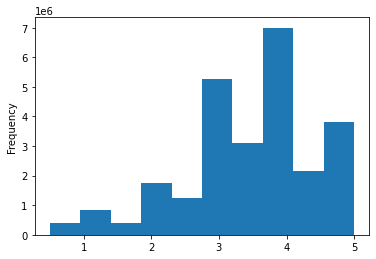

In [87]:
# inspect ratings statistics 
# look at histogram of rating distributions, use describe() to print out stats
pd.options.display.float_format='{:20,.2f}'.format
ratings['rating'].plot(kind='hist')
ratings['rating'].describe()